In [ ]:
pip install scikit-plot

In [ ]:
import librosa
import glob
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf
import json
import pandas as pd
from keras.layers import Conv2D, Dense, Dropout, Flatten, AveragePooling2D, Activation, MaxPooling2D
from keras.optimizers import Adam
from keras import optimizers
from keras.models import Sequential

import keras 
from keras.layers import Conv1D, BatchNormalization, MaxPool2D, MaxPooling1D, LSTM
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical

import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
pd.options.display.max_rows = 999999
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import scipy


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/datasets/CREMA_D/AudioWAV/"

ActorID = []
Statement = []
Emotion  = []
Emotional_level = []
Paths = []

links = os.listdir(DATA_PATH)
for f in links:
  file_path = os.path.join(DATA_PATH, f)
  Paths.append(file_path)
  ActorID.append(f.split('.')[0].split('_')[0])
  Statement.append(f.split('.')[0].split('_')[1])
  Emotion.append(f.split('.')[0].split('_')[2])
  Emotional_level.append(f.split('.')[0].split('_')[3])

CREMA_D_df = pd.DataFrame()
CREMA_D_df['ActorID'] = ActorID
CREMA_D_df['Statement'] = Statement
CREMA_D_df['Emotion'] = Emotion
CREMA_D_df['Emotional_level'] = Emotional_level
CREMA_D_df['Paths'] = Paths


# mfcc_13 + basic model

In [ ]:
data = {'labels': [],
        'features': []}

for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      data['labels'].append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      data['labels'].append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      data['labels'].append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      data['labels'].append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])
    mfcc = np.mean(librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13).T,axis=0).tolist()
    data['features'].append(mfcc)

In [ ]:
X = data['features']
y = data['labels']

y = np.array(data['labels'])
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

## basic model:

In [ ]:
model = Sequential()
model.add(Dense(13, input_shape=(13, ), activation = 'relu'))
#model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(4, activation = 'softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 13)                182       
_________________________________________________________________
dense_9 (Dense)              (None, 128)               1792      
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 516       
Total params: 19,002
Trainable params: 19,002
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=200, 
                    validation_data=(X_val, y_val))

Epoch 1/200
65/65 [==============================] - 1s 7ms/step - loss: 4.5049 - accuracy: 0.3124 - val_loss: 1.4361 - val_accuracy: 0.4083
Epoch 2/200
65/65 [==============================] - 0s 2ms/step - loss: 1.3354 - accuracy: 0.3990 - val_loss: 2.3611 - val_accuracy: 0.2533
Epoch 3/200
65/65 [==============================] - 0s 2ms/step - loss: 1.7035 - accuracy: 0.3541 - val_loss: 1.2757 - val_accuracy: 0.4192
Epoch 4/200
65/65 [==============================] - 0s 2ms/step - loss: 1.2502 - accuracy: 0.4153 - val_loss: 1.3721 - val_accuracy: 0.4105
Epoch 5/200
65/65 [==============================] - 0s 2ms/step - loss: 1.3076 - accuracy: 0.4074 - val_loss: 1.2565 - val_accuracy: 0.4454
Epoch 6/200
65/65 [==============================] - 0s 2ms/step - loss: 1.3355 - accuracy: 0.4065 - val_loss: 1.3161 - val_accuracy: 0.4039
Epoch 7/200
65/65 [==============================] - 0s 3ms/step - loss: 1.3154 - accuracy: 0.4229 - val_loss: 1.1782 - val_accuracy: 0.4410
Epoch 8/200
6

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/basic_mfcc13_cremad.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.67      0.62      0.65       136
        fear       0.43      0.43      0.43       134
       happy       0.47      0.45      0.46       120
         sad       0.61      0.70      0.65       119

    accuracy                           0.55       509
   macro avg       0.55      0.55      0.55       509
weighted avg       0.55      0.55      0.55       509



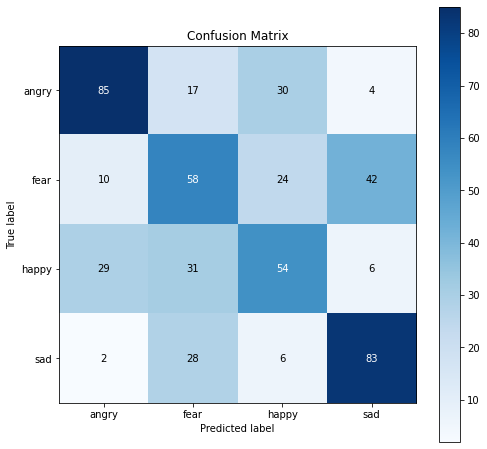

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))


# mfcc_26 + basic model

In [ ]:
data = {'labels': [],
        'features': []}

for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      data['labels'].append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      data['labels'].append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      data['labels'].append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      data['labels'].append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])
    mfcc = np.mean(librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=26).T,axis=0).tolist()
    data['features'].append(mfcc)

In [ ]:
X = data['features']
y = data['labels']

y = np.array(data['labels'])
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

## basic model:

In [ ]:
model = Sequential()
model.add(Dense(26, input_shape=(26, ), activation = 'relu'))
#model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(4, activation = 'softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 26)                702       
_________________________________________________________________
dense_13 (Dense)             (None, 128)               3456      
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 516       
Total params: 21,186
Trainable params: 21,186
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=200, 
                    validation_data=(X_val, y_val))

Epoch 1/200
65/65 [==============================] - 1s 8ms/step - loss: 5.4713 - accuracy: 0.2847 - val_loss: 1.4014 - val_accuracy: 0.3450
Epoch 2/200
65/65 [==============================] - 0s 3ms/step - loss: 1.3078 - accuracy: 0.4327 - val_loss: 1.2215 - val_accuracy: 0.4585
Epoch 3/200
65/65 [==============================] - 0s 2ms/step - loss: 1.1802 - accuracy: 0.4670 - val_loss: 1.1541 - val_accuracy: 0.4716
Epoch 4/200
65/65 [==============================] - 0s 2ms/step - loss: 1.2250 - accuracy: 0.4520 - val_loss: 1.3797 - val_accuracy: 0.4105
Epoch 5/200
65/65 [==============================] - 0s 2ms/step - loss: 1.3191 - accuracy: 0.4213 - val_loss: 1.3507 - val_accuracy: 0.4454
Epoch 6/200
65/65 [==============================] - 0s 2ms/step - loss: 1.2066 - accuracy: 0.4590 - val_loss: 1.4735 - val_accuracy: 0.3603
Epoch 7/200
65/65 [==============================] - 0s 3ms/step - loss: 1.1692 - accuracy: 0.4803 - val_loss: 1.1981 - val_accuracy: 0.4367
Epoch 8/200
6

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/basic_mfcc26_cremad.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.59      0.60      0.59       136
        fear       0.42      0.38      0.40       134
       happy       0.38      0.49      0.43       120
         sad       0.65      0.52      0.58       119

    accuracy                           0.50       509
   macro avg       0.51      0.50      0.50       509
weighted avg       0.51      0.50      0.50       509



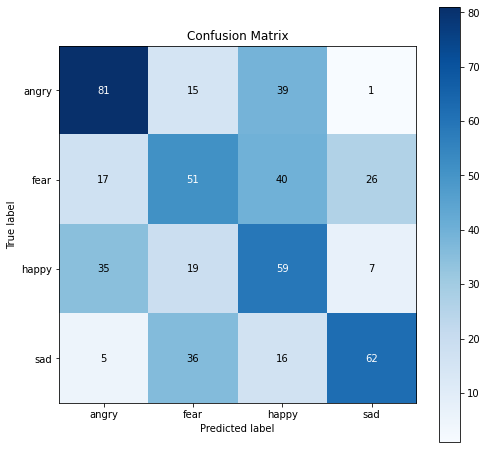

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))


# mfcc_39 + basic model

In [ ]:
data = {'labels': [],
        'features': []}

for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      data['labels'].append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      data['labels'].append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      data['labels'].append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      data['labels'].append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])
    mfcc = np.mean(librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=39).T,axis=0).tolist()
    data['features'].append(mfcc)

In [ ]:
X = data['features']
y = data['labels']

y = np.array(data['labels'])
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

## basic model:

In [ ]:
model = Sequential()
model.add(Dense(39, input_shape=(39, ), activation = 'relu'))
#model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(4, activation = 'softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 39)                1560      
_________________________________________________________________
dense_17 (Dense)             (None, 128)               5120      
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 516       
Total params: 23,708
Trainable params: 23,708
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=200, 
                    validation_data=(X_val, y_val))

Epoch 1/200
65/65 [==============================] - 1s 7ms/step - loss: 6.1641 - accuracy: 0.3211 - val_loss: 1.5156 - val_accuracy: 0.3668
Epoch 2/200
65/65 [==============================] - 0s 2ms/step - loss: 1.3711 - accuracy: 0.4141 - val_loss: 1.4710 - val_accuracy: 0.4192
Epoch 3/200
65/65 [==============================] - 0s 3ms/step - loss: 1.3542 - accuracy: 0.4126 - val_loss: 1.3285 - val_accuracy: 0.3865
Epoch 4/200
65/65 [==============================] - 0s 2ms/step - loss: 1.3851 - accuracy: 0.4095 - val_loss: 1.1999 - val_accuracy: 0.4389
Epoch 5/200
65/65 [==============================] - 0s 2ms/step - loss: 1.3650 - accuracy: 0.4133 - val_loss: 1.1296 - val_accuracy: 0.4934
Epoch 6/200
65/65 [==============================] - 0s 2ms/step - loss: 1.2298 - accuracy: 0.4660 - val_loss: 1.2965 - val_accuracy: 0.4345
Epoch 7/200
65/65 [==============================] - 0s 2ms/step - loss: 1.2742 - accuracy: 0.4395 - val_loss: 1.5124 - val_accuracy: 0.4476
Epoch 8/200
6

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/basic_mfcc39_cremad.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.60      0.49      0.54       136
        fear       0.50      0.49      0.49       134
       happy       0.45      0.50      0.47       120
         sad       0.65      0.73      0.69       119

    accuracy                           0.55       509
   macro avg       0.55      0.55      0.55       509
weighted avg       0.55      0.55      0.55       509



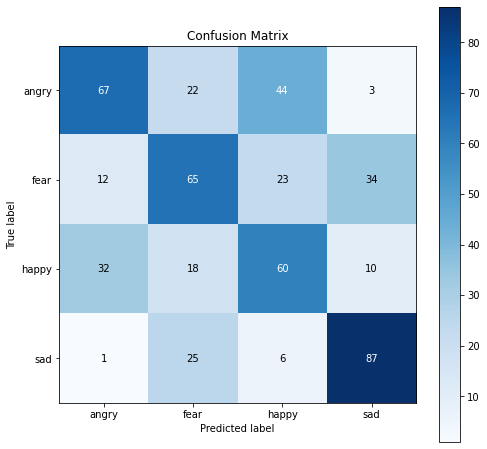

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# mfcc_13 + conv1D

In [ ]:
audio_duration = 3
sampling_rate = 22050
input_length = sampling_rate * audio_duration

In [ ]:
data = {'labels': [],
        'features': []}

for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      data['labels'].append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      data['labels'].append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      data['labels'].append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      data['labels'].append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])

    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")

    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13).T
    mfcc = mfcc.reshape(-1,1)
    data['features'].append(mfcc)

In [ ]:
X = data['features']
y = data['labels']

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((4117, 1690, 1), (509, 1690, 1), (4117, 4), (509, 4))

In [ ]:

# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

#LSTM Configuration
num_lstm = 256

In [ ]:
model = Sequential(name='Audio_CNN_1D')

# LFLB1
model.add(Conv1D(filters=64, kernel_size=(3), strides=1, padding='same', data_format='channels_last',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.5))

# LFLB2
model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB3
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB4
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LSTM
model.add(LSTM(units=num_lstm))

# FC
model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt= keras.optimizers.Adam(lr=0.01, beta_1=0.9,  beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()


Model: "Audio_CNN_1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1690, 64)          256       
_________________________________________________________________
batch_normalization (BatchNo (None, 1690, 64)          256       
_________________________________________________________________
activation (Activation)      (None, 1690, 64)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 422, 64)           0         
_________________________________________________________________
dropout (Dropout)            (None, 422, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 422, 64)           12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 422, 64)          

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Audio_1DCNN.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
258/258 [==============================] - 45s 130ms/step - loss: 1.3101 - categorical_accuracy: 0.4457 - val_loss: 1.6579 - val_categorical_accuracy: 0.3166
Epoch 2/200
258/258 [==============================] - 33s 128ms/step - loss: 1.0522 - categorical_accuracy: 0.5384 - val_loss: 1.2154 - val_categorical_accuracy: 0.4651
Epoch 3/200
258/258 [==============================] - 32s 124ms/step - loss: 1.0399 - categorical_accuracy: 0.5320 - val_loss: 1.0990 - val_categorical_accuracy: 0.4978
Epoch 4/200
258/258 [==============================] - 32s 124ms/step - loss: 1.0665 - categorical_accuracy: 0.5056 - val_loss: 1.0735 - val_categorical_accuracy: 0.4869
Epoch 5/200
258/258 [==============================] - 32s 124ms/step - loss: 1.0780 - categorical_accuracy: 0.5106 - val_loss: 1.3035 - val_categorical_accuracy: 0.4585
Epoch 6/200
258/258 [==============================] - 32s 125ms/step - loss: 1.0684 - categorical_accuracy: 0.5191 - val_loss: 1.2374 - val_categoric

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/conv1D_mfcc13_cremad.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.76      0.54      0.64       136
        fear       0.45      0.75      0.56       134
       happy       0.49      0.53      0.51       120
         sad       0.79      0.39      0.52       119

    accuracy                           0.56       509
   macro avg       0.62      0.55      0.56       509
weighted avg       0.62      0.56      0.56       509



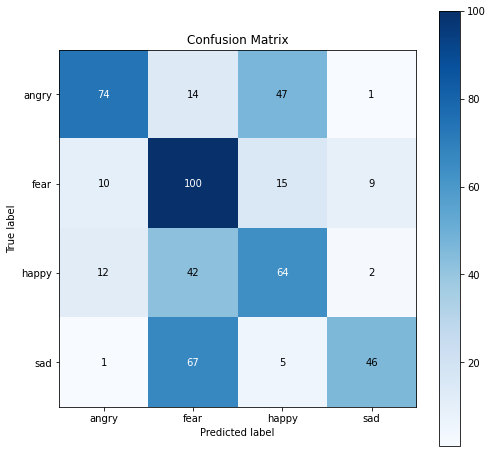

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# mfcc_26 + conv1D

In [ ]:
audio_duration = 3
sampling_rate = 22050
input_length = sampling_rate * audio_duration

In [ ]:
data = {'labels': [],
        'features': []}

for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      data['labels'].append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      data['labels'].append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      data['labels'].append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      data['labels'].append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])

    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")

    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=26).T
    mfcc = mfcc.reshape(-1,1)
    data['features'].append(mfcc)

In [ ]:
X = data['features']
y = data['labels']

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((4117, 3380, 1), (509, 3380, 1), (4117, 4), (509, 4))

In [ ]:

# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

#LSTM Configuration
num_lstm = 256

In [ ]:
model = Sequential(name='Audio_CNN_1D')

# LFLB1
model.add(Conv1D(filters=64, kernel_size=(3), strides=1, padding='same', data_format='channels_last',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.5))

# LFLB2
model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB3
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB4
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LSTM
model.add(LSTM(units=num_lstm))

# FC
model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt= keras.optimizers.Adam(lr=0.01, beta_1=0.9,  beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()


Model: "Audio_CNN_1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3380, 64)          256       
_________________________________________________________________
batch_normalization (BatchNo (None, 3380, 64)          256       
_________________________________________________________________
activation (Activation)      (None, 3380, 64)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 845, 64)           0         
_________________________________________________________________
dropout (Dropout)            (None, 845, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 845, 64)           12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 845, 64)          

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Audio_1DCNN.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
258/258 [==============================] - 57s 18ms/step - loss: 1.3544 - categorical_accuracy: 0.4283 - val_loss: 1.9161 - val_categorical_accuracy: 0.2817
Epoch 2/200
258/258 [==============================] - 3s 12ms/step - loss: 1.1245 - categorical_accuracy: 0.4637 - val_loss: 1.9937 - val_categorical_accuracy: 0.3035
Epoch 3/200
258/258 [==============================] - 3s 12ms/step - loss: 1.0976 - categorical_accuracy: 0.5172 - val_loss: 1.3214 - val_categorical_accuracy: 0.3908
Epoch 4/200
258/258 [==============================] - 3s 12ms/step - loss: 1.1015 - categorical_accuracy: 0.5070 - val_loss: 1.1510 - val_categorical_accuracy: 0.4760
Epoch 5/200
258/258 [==============================] - 3s 12ms/step - loss: 1.0809 - categorical_accuracy: 0.5161 - val_loss: 1.1258 - val_categorical_accuracy: 0.4956
Epoch 6/200
258/258 [==============================] - 3s 12ms/step - loss: 1.0821 - categorical_accuracy: 0.5154 - val_loss: 1.3558 - val_categorical_accuracy

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/conv1D_mfcc26_cremad.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.83      0.54      0.66       136
        fear       0.42      0.66      0.52       134
       happy       0.50      0.45      0.48       120
         sad       0.65      0.55      0.60       119

    accuracy                           0.56       509
   macro avg       0.60      0.55      0.56       509
weighted avg       0.60      0.56      0.56       509



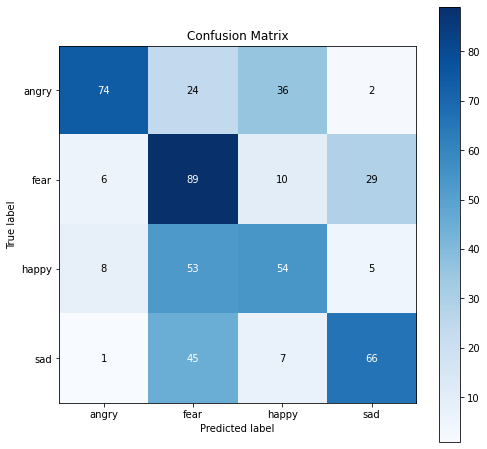

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# mfcc_39 + conv1D

In [ ]:
audio_duration = 3
sampling_rate = 22050
input_length = sampling_rate * audio_duration

In [ ]:
data = {'labels': [],
        'features': []}

for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      data['labels'].append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      data['labels'].append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      data['labels'].append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      data['labels'].append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])

    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")

    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=39).T
    mfcc = mfcc.reshape(-1,1)
    data['features'].append(mfcc)

In [ ]:
X = data['features']
y = data['labels']

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((4117, 5070, 1), (509, 5070, 1), (4117, 4), (509, 4))

In [ ]:

# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

#LSTM Configuration
num_lstm = 256

In [ ]:
model = Sequential(name='Audio_CNN_1D')

# LFLB1
model.add(Conv1D(filters=64, kernel_size=(3), strides=1, padding='same', data_format='channels_last',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.5))

# LFLB2
model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB3
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB4
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LSTM
model.add(LSTM(units=num_lstm))

# FC
model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt= keras.optimizers.Adam(lr=0.01, beta_1=0.9,  beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()


Model: "Audio_CNN_1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 5070, 64)          256       
_________________________________________________________________
batch_normalization_4 (Batch (None, 5070, 64)          256       
_________________________________________________________________
activation_4 (Activation)    (None, 5070, 64)          0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 1267, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1267, 64)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1267, 64)          12352     
_________________________________________________________________
batch_normalization_5 (Batch (None, 1267, 64)         

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Audio_1DCNN.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
258/258 [==============================] - 9s 20ms/step - loss: 1.4048 - categorical_accuracy: 0.4170 - val_loss: 1.6584 - val_categorical_accuracy: 0.2707
Epoch 2/200
258/258 [==============================] - 4s 15ms/step - loss: 1.1258 - categorical_accuracy: 0.4800 - val_loss: 1.6398 - val_categorical_accuracy: 0.2052
Epoch 3/200
258/258 [==============================] - 4s 15ms/step - loss: 1.1063 - categorical_accuracy: 0.4961 - val_loss: 1.4347 - val_categorical_accuracy: 0.2729
Epoch 4/200
258/258 [==============================] - 4s 16ms/step - loss: 1.0883 - categorical_accuracy: 0.4932 - val_loss: 1.2630 - val_categorical_accuracy: 0.3734
Epoch 5/200
258/258 [==============================] - 4s 15ms/step - loss: 1.1365 - categorical_accuracy: 0.4715 - val_loss: 1.1851 - val_categorical_accuracy: 0.4782
Epoch 6/200
258/258 [==============================] - 4s 15ms/step - loss: 1.1395 - categorical_accuracy: 0.4656 - val_loss: 1.2200 - val_categorical_accuracy:

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/conv1D_mfcc39_cremad.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.67      0.60      0.63       136
        fear       0.42      0.44      0.43       134
       happy       0.49      0.53      0.51       120
         sad       0.66      0.66      0.66       119

    accuracy                           0.55       509
   macro avg       0.56      0.56      0.56       509
weighted avg       0.56      0.55      0.56       509



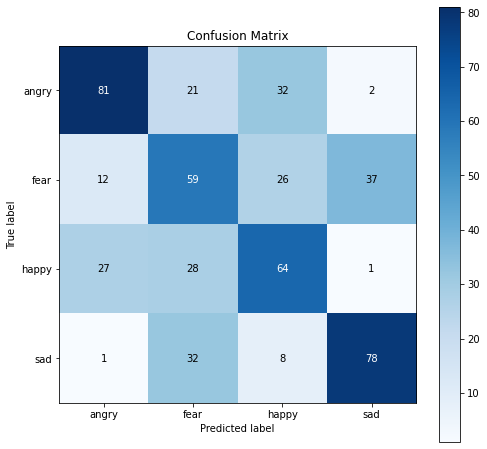

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# mfcc_13 + conv2D:

In [ ]:
audio_duration = 3
sampling_rate = 22050
input_length = sampling_rate * audio_duration

In [ ]:
data = {'labels': [],
        'features': []}

for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      data['labels'].append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      data['labels'].append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      data['labels'].append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      data['labels'].append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])

    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")

    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13).T
    mfcc = np.expand_dims(mfcc, axis=-1)
    data['features'].append(mfcc)

In [ ]:
X = data['features']
y = data['labels']

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((4117, 130, 13, 1), (509, 130, 13, 1), (4117, 4), (509, 4))

In [ ]:
# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

In [ ]:
model = Sequential(name='Audio_CNN_2D')

# LFLB1
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt = optimizers.SGD(lr=learning_rate, decay=decay, momentum=momentum, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()

Model: "Audio_CNN_2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 130, 13, 64)       640       
_________________________________________________________________
batch_normalization_8 (Batch (None, 130, 13, 64)       256       
_________________________________________________________________
activation_8 (Activation)    (None, 130, 13, 64)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 6, 64)         0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 65, 6, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 65, 6, 64)         36928     
_________________________________________________________________
batch_normalization_9 (Batch (None, 65, 6, 64)        

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Modelfull_2_1.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
258/258 [==============================] - 4s 6ms/step - loss: 2.5078 - categorical_accuracy: 0.2934 - val_loss: 1.7122 - val_categorical_accuracy: 0.2904
Epoch 2/200
258/258 [==============================] - 1s 4ms/step - loss: 1.8384 - categorical_accuracy: 0.3787 - val_loss: 1.3824 - val_categorical_accuracy: 0.3930
Epoch 3/200
258/258 [==============================] - 1s 4ms/step - loss: 1.6142 - categorical_accuracy: 0.4001 - val_loss: 1.2159 - val_categorical_accuracy: 0.4170
Epoch 4/200
258/258 [==============================] - 1s 4ms/step - loss: 1.4596 - categorical_accuracy: 0.4218 - val_loss: 1.1130 - val_categorical_accuracy: 0.4934
Epoch 5/200
258/258 [==============================] - 1s 4ms/step - loss: 1.3869 - categorical_accuracy: 0.4313 - val_loss: 1.1165 - val_categorical_accuracy: 0.4672
Epoch 6/200
258/258 [==============================] - 1s 4ms/step - loss: 1.3108 - categorical_accuracy: 0.4470 - val_loss: 1.1289 - val_categorical_accuracy: 0.478

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/conv2D_mfcc13_cremad.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.58      0.81      0.67       136
        fear       0.52      0.55      0.54       134
       happy       0.57      0.36      0.44       120
         sad       0.68      0.58      0.63       119

    accuracy                           0.58       509
   macro avg       0.59      0.57      0.57       509
weighted avg       0.58      0.58      0.57       509



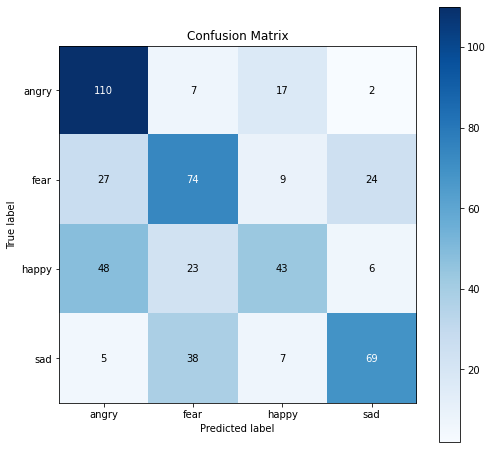

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# mfcc_26 + conv2D:

In [ ]:
audio_duration = 3
sampling_rate = 22050
input_length = sampling_rate * audio_duration

In [ ]:
data = {'labels': [],
        'features': []}

for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      data['labels'].append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      data['labels'].append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      data['labels'].append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      data['labels'].append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])

    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")

    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=26).T
    mfcc = np.expand_dims(mfcc, axis=-1)
    data['features'].append(mfcc)

In [ ]:
X = data['features']
y = data['labels']

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((4117, 130, 26, 1), (509, 130, 26, 1), (4117, 4), (509, 4))

In [ ]:
# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

In [ ]:
model = Sequential(name='Audio_CNN_2D')

# LFLB1
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt = optimizers.SGD(lr=learning_rate, decay=decay, momentum=momentum, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()

Model: "Audio_CNN_2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 130, 26, 64)       640       
_________________________________________________________________
batch_normalization_10 (Batc (None, 130, 26, 64)       256       
_________________________________________________________________
activation_10 (Activation)   (None, 130, 26, 64)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 65, 13, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 65, 13, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 13, 64)        36928     
_________________________________________________________________
batch_normalization_11 (Batc (None, 65, 13, 64)       

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Modelfull_2_1.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
258/258 [==============================] - 4s 9ms/step - loss: 2.2322 - categorical_accuracy: 0.2838 - val_loss: 1.2963 - val_categorical_accuracy: 0.3974
Epoch 2/200
258/258 [==============================] - 2s 6ms/step - loss: 1.5000 - categorical_accuracy: 0.4127 - val_loss: 1.1697 - val_categorical_accuracy: 0.4716
Epoch 3/200
258/258 [==============================] - 2s 6ms/step - loss: 1.3162 - categorical_accuracy: 0.4406 - val_loss: 1.1158 - val_categorical_accuracy: 0.5000
Epoch 4/200
258/258 [==============================] - 2s 6ms/step - loss: 1.2327 - categorical_accuracy: 0.4597 - val_loss: 1.1566 - val_categorical_accuracy: 0.4389
Epoch 5/200
258/258 [==============================] - 2s 6ms/step - loss: 1.1901 - categorical_accuracy: 0.4738 - val_loss: 1.1058 - val_categorical_accuracy: 0.4607
Epoch 6/200
258/258 [==============================] - 2s 6ms/step - loss: 1.1549 - categorical_accuracy: 0.4927 - val_loss: 1.1149 - val_categorical_accuracy: 0.434

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/conv2D_mfcc26_cremad.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.72      0.72      0.72       136
        fear       0.56      0.50      0.53       134
       happy       0.60      0.62      0.61       120
         sad       0.67      0.71      0.69       119

    accuracy                           0.64       509
   macro avg       0.64      0.64      0.64       509
weighted avg       0.64      0.64      0.64       509



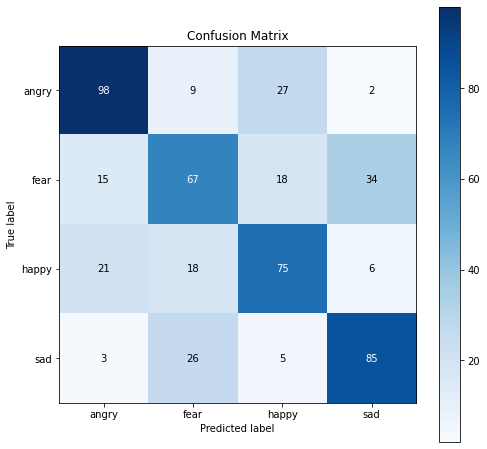

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# mfcc_39 + conv2D:

In [ ]:
audio_duration = 3
sampling_rate = 22050
input_length = sampling_rate * audio_duration

In [ ]:
data = {'labels': [],
        'features': []}

for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      data['labels'].append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      data['labels'].append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      data['labels'].append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      data['labels'].append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])

    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")

    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=39).T
    mfcc = np.expand_dims(mfcc, axis=-1)
    data['features'].append(mfcc)

In [ ]:
X = data['features']
y = data['labels']

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((4117, 130, 39, 1), (509, 130, 39, 1), (4117, 4), (509, 4))

In [ ]:
# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

In [ ]:
model = Sequential(name='Audio_CNN_2D')

# LFLB1
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt = optimizers.SGD(lr=learning_rate, decay=decay, momentum=momentum, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()

Model: "Audio_CNN_2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 130, 39, 64)       640       
_________________________________________________________________
batch_normalization_12 (Batc (None, 130, 39, 64)       256       
_________________________________________________________________
activation_12 (Activation)   (None, 130, 39, 64)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 65, 19, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 65, 19, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 65, 19, 64)        36928     
_________________________________________________________________
batch_normalization_13 (Batc (None, 65, 19, 64)       

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Modelfull_2_1.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
258/258 [==============================] - 4s 10ms/step - loss: 2.2613 - categorical_accuracy: 0.3076 - val_loss: 1.3784 - val_categorical_accuracy: 0.3974
Epoch 2/200
258/258 [==============================] - 2s 7ms/step - loss: 1.5011 - categorical_accuracy: 0.4073 - val_loss: 1.2650 - val_categorical_accuracy: 0.4105
Epoch 3/200
258/258 [==============================] - 2s 7ms/step - loss: 1.3009 - categorical_accuracy: 0.4525 - val_loss: 1.2170 - val_categorical_accuracy: 0.4367
Epoch 4/200
258/258 [==============================] - 2s 7ms/step - loss: 1.2123 - categorical_accuracy: 0.4789 - val_loss: 1.1826 - val_categorical_accuracy: 0.3821
Epoch 5/200
258/258 [==============================] - 2s 7ms/step - loss: 1.1489 - categorical_accuracy: 0.4870 - val_loss: 1.1042 - val_categorical_accuracy: 0.4629
Epoch 6/200
258/258 [==============================] - 2s 7ms/step - loss: 1.1622 - categorical_accuracy: 0.4981 - val_loss: 1.1691 - val_categorical_accuracy: 0.41

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/conv2D_mfcc39_cremad.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.77      0.74      0.75       136
        fear       0.53      0.65      0.58       134
       happy       0.61      0.53      0.57       120
         sad       0.68      0.62      0.65       119

    accuracy                           0.64       509
   macro avg       0.65      0.63      0.64       509
weighted avg       0.65      0.64      0.64       509



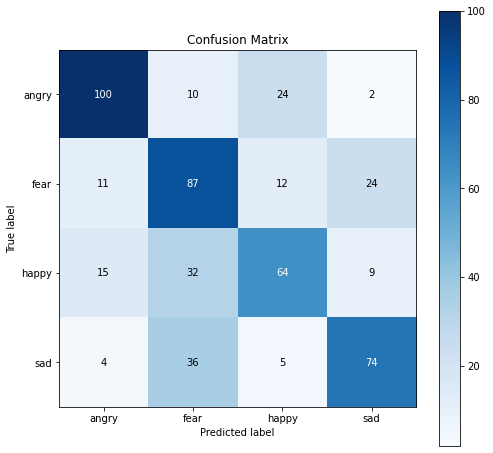

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# Mel Spectrogram + basic model

In [ ]:
audio_duration = 3
sampling_rate = 44100
input_length = sampling_rate * audio_duration


In [ ]:
data = {'labels': [],
        'features': []}

for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      data['labels'].append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      data['labels'].append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      data['labels'].append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      data['labels'].append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])


    if len(signal) > input_length:
      signal = signal[0:input_length]
    elif  input_length > len(signal):
      max_offset = input_length - len(signal)  
      signal = np.pad(signal, (0, max_offset), "constant")

    melspec = librosa.feature.melspectrogram(signal, sr=sampling_rate, n_mels=128,n_fft=2048,hop_length=512)   
    melspec = np.mean(melspec, axis=0)
    data['features'].append(melspec)


In [ ]:
X = data['features']
y = data['labels']

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape

(4117, 259)

## basic models:

In [ ]:
model = Sequential()
model.add(Dense(259, input_shape=(259, ), activation = 'relu'))
#model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(4, activation = 'softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 259)               67340     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               33280     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 516       
Total params: 117,648
Trainable params: 117,648
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=200, 
                    validation_data=(X_val, y_val))

Epoch 1/200
65/65 [==============================] - 1s 7ms/step - loss: 1.3363 - accuracy: 0.3656 - val_loss: 1.2311 - val_accuracy: 0.4782
Epoch 2/200
65/65 [==============================] - 0s 3ms/step - loss: 1.0946 - accuracy: 0.5162 - val_loss: 1.1579 - val_accuracy: 0.4760
Epoch 3/200
65/65 [==============================] - 0s 3ms/step - loss: 1.0161 - accuracy: 0.5575 - val_loss: 1.1622 - val_accuracy: 0.4803
Epoch 4/200
65/65 [==============================] - 0s 4ms/step - loss: 0.9580 - accuracy: 0.5877 - val_loss: 1.1447 - val_accuracy: 0.5022
Epoch 5/200
65/65 [==============================] - 0s 3ms/step - loss: 0.9333 - accuracy: 0.5887 - val_loss: 1.1802 - val_accuracy: 0.4760
Epoch 6/200
65/65 [==============================] - 0s 3ms/step - loss: 0.9224 - accuracy: 0.5956 - val_loss: 1.1780 - val_accuracy: 0.4956
Epoch 7/200
65/65 [==============================] - 0s 3ms/step - loss: 0.8901 - accuracy: 0.6157 - val_loss: 1.1910 - val_accuracy: 0.4978
Epoch 8/200
6

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/basic_melspec_cremad.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.61      0.57      0.59       136
        fear       0.35      0.28      0.31       134
       happy       0.38      0.42      0.40       120
         sad       0.49      0.60      0.54       119

    accuracy                           0.46       509
   macro avg       0.46      0.46      0.46       509
weighted avg       0.46      0.46      0.46       509



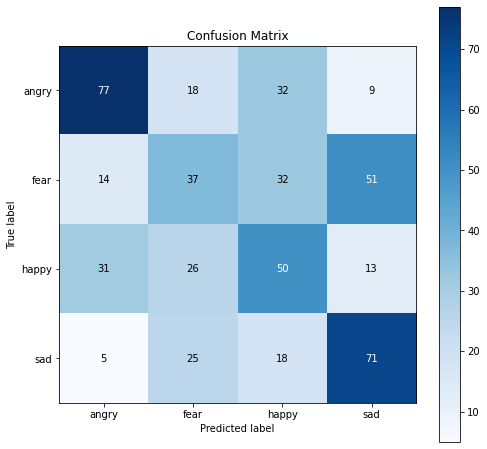

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# Mel Spectrogram + conv1D

In [ ]:
audio_duration = 3
sampling_rate = 44100
input_length = sampling_rate * audio_duration


In [ ]:
data = {'labels': [],
        'features': []}

for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      data['labels'].append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      data['labels'].append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      data['labels'].append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      data['labels'].append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])

    if len(signal) > input_length:
      signal = signal[0:input_length]
    elif  input_length > len(signal):
      max_offset = input_length - len(signal)  
      signal = np.pad(signal, (0, max_offset), "constant")

    melspec = librosa.feature.melspectrogram(signal, sr=sampling_rate, n_mels=128,n_fft=2048,hop_length=512)   
    melspec = melspec.reshape(-1,1)
    data['features'].append(melspec)


In [ ]:
X = data['features']
y = data['labels']

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((4117, 33152, 1), (509, 33152, 1), (4117, 4), (509, 4))

### conv1D

In [ ]:

# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

#LSTM Configuration
num_lstm = 256

In [ ]:
model = Sequential(name='Audio_CNN_1D')

# LFLB1
model.add(Conv1D(filters=64, kernel_size=(3), strides=1, padding='same', data_format='channels_last',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.5))

# LFLB2
model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB3
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB4
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LSTM
model.add(LSTM(units=num_lstm))

# FC
model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt= keras.optimizers.Adam(lr=0.01, beta_1=0.9,  beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()


Model: "Audio_CNN_1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 33152, 64)         256       
_________________________________________________________________
batch_normalization_14 (Batc (None, 33152, 64)         256       
_________________________________________________________________
activation_14 (Activation)   (None, 33152, 64)         0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 8288, 64)          0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 8288, 64)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 8288, 64)          12352     
_________________________________________________________________
batch_normalization_15 (Batc (None, 8288, 64)         

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Audio_1DCNN.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
258/258 [==============================] - 24s 79ms/step - loss: 1.4625 - categorical_accuracy: 0.2614 - val_loss: 1.3501 - val_categorical_accuracy: 0.4127
Epoch 2/200
258/258 [==============================] - 19s 75ms/step - loss: 1.2508 - categorical_accuracy: 0.4250 - val_loss: 1.2921 - val_categorical_accuracy: 0.3428
Epoch 3/200
258/258 [==============================] - 19s 75ms/step - loss: 1.1852 - categorical_accuracy: 0.4522 - val_loss: 1.2456 - val_categorical_accuracy: 0.4389
Epoch 4/200
258/258 [==============================] - 19s 75ms/step - loss: 1.1931 - categorical_accuracy: 0.4474 - val_loss: 1.4076 - val_categorical_accuracy: 0.4148
Epoch 5/200
258/258 [==============================] - 19s 75ms/step - loss: 1.1934 - categorical_accuracy: 0.4569 - val_loss: 1.1471 - val_categorical_accuracy: 0.4847
Epoch 6/200
258/258 [==============================] - 19s 75ms/step - loss: 1.2734 - categorical_accuracy: 0.4299 - val_loss: 1.2264 - val_categorical_acc

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/conv1D_melspec_cremad.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.63      0.34      0.44       136
        fear       0.43      0.02      0.04       134
       happy       0.38      0.53      0.44       120
         sad       0.42      0.94      0.58       119

    accuracy                           0.44       509
   macro avg       0.47      0.46      0.38       509
weighted avg       0.47      0.44      0.37       509



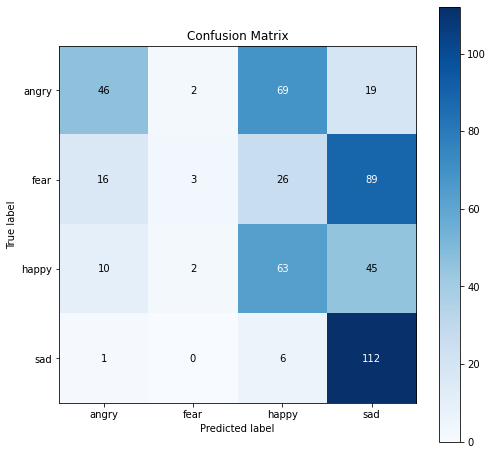

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# Mel Spectrogram + conv2D:

In [ ]:
audio_duration = 3
sampling_rate = 44100
input_length = sampling_rate * audio_duration


In [ ]:
data = {'labels': [],
        'features': []}

for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      data['labels'].append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      data['labels'].append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      data['labels'].append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      data['labels'].append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])

    if len(signal) > input_length:
      signal = signal[0:input_length]
    elif  input_length > len(signal):
      max_offset = input_length - len(signal)  
      signal = np.pad(signal, (0, max_offset), "constant")

    melspec = librosa.feature.melspectrogram(signal, sr=sampling_rate, n_mels=128,n_fft=2048,hop_length=512)   
    melspec = np.expand_dims(melspec, axis=-1)

    data['features'].append(melspec)

In [ ]:
X = data['features']
y = data['labels']

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((4117, 128, 259, 1), (509, 128, 259, 1), (4117, 4), (509, 4))

### conv2D

In [ ]:
# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

In [ ]:
model = Sequential(name='Audio_CNN_2D')

# LFLB1
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt = optimizers.SGD(lr=learning_rate, decay=decay, momentum=momentum, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()

Model: "Audio_CNN_2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 259, 64)      640       
_________________________________________________________________
batch_normalization_18 (Batc (None, 128, 259, 64)      256       
_________________________________________________________________
activation_18 (Activation)   (None, 128, 259, 64)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 129, 64)       0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 64, 129, 64)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 129, 64)       36928     
_________________________________________________________________
batch_normalization_19 (Batc (None, 64, 129, 64)      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Modelfull_2_1.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
258/258 [==============================] - 11s 35ms/step - loss: 3.0638 - categorical_accuracy: 0.3682 - val_loss: 1.3190 - val_categorical_accuracy: 0.4061
Epoch 2/200
258/258 [==============================] - 8s 32ms/step - loss: 1.4415 - categorical_accuracy: 0.4591 - val_loss: 1.2920 - val_categorical_accuracy: 0.3624
Epoch 3/200
258/258 [==============================] - 8s 32ms/step - loss: 1.3072 - categorical_accuracy: 0.4675 - val_loss: 1.3284 - val_categorical_accuracy: 0.3144
Epoch 4/200
258/258 [==============================] - 8s 32ms/step - loss: 1.2463 - categorical_accuracy: 0.4544 - val_loss: 1.3349 - val_categorical_accuracy: 0.3144
Epoch 5/200
258/258 [==============================] - 8s 32ms/step - loss: 1.2519 - categorical_accuracy: 0.4581 - val_loss: 1.3700 - val_categorical_accuracy: 0.3013
Epoch 6/200
258/258 [==============================] - 8s 32ms/step - loss: 1.2097 - categorical_accuracy: 0.4577 - val_loss: 1.3802 - val_categorical_accuracy

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/conv2D_melspec_cremad.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.66      0.34      0.45       136
        fear       0.33      0.13      0.18       134
       happy       0.45      0.45      0.45       120
         sad       0.43      0.97      0.60       119

    accuracy                           0.46       509
   macro avg       0.47      0.47      0.42       509
weighted avg       0.47      0.46      0.41       509



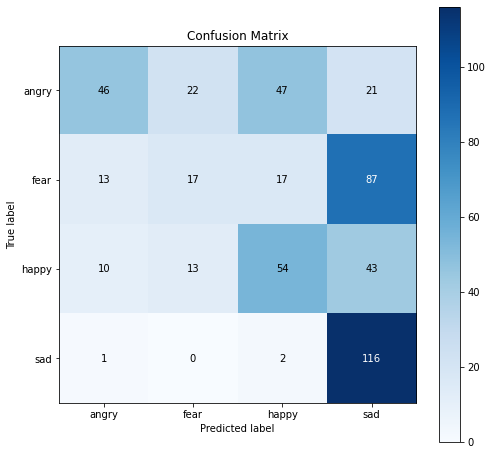

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# Tempogram + basic model

In [ ]:
data = {'labels': [],
        'features': []}

for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      data['labels'].append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      data['labels'].append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      data['labels'].append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      data['labels'].append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])

    tempogram = np.mean(librosa.feature.tempogram(signal, sr).T, axis=0)
    data['features'].append(tempogram)


In [ ]:
X = data['features']
y = data['labels']

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

## basic models:

In [ ]:
model = Sequential()
model.add(Dense(384, input_shape=(384, ), activation = 'relu'))
#model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(4, activation = 'softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 384)               147840    
_________________________________________________________________
dense_12 (Dense)             (None, 128)               49280     
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 516       
Total params: 214,148
Trainable params: 214,148
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=200, 
                    validation_data=(X_val, y_val))

Epoch 1/200
65/65 [==============================] - 1s 8ms/step - loss: 1.3233 - accuracy: 0.3312 - val_loss: 1.2187 - val_accuracy: 0.4127
Epoch 2/200
65/65 [==============================] - 0s 4ms/step - loss: 1.1546 - accuracy: 0.4527 - val_loss: 1.1056 - val_accuracy: 0.5044
Epoch 3/200
65/65 [==============================] - 0s 3ms/step - loss: 1.0584 - accuracy: 0.5068 - val_loss: 1.1246 - val_accuracy: 0.4956
Epoch 4/200
65/65 [==============================] - 0s 3ms/step - loss: 1.0643 - accuracy: 0.5013 - val_loss: 1.1241 - val_accuracy: 0.4803
Epoch 5/200
65/65 [==============================] - 0s 3ms/step - loss: 1.0560 - accuracy: 0.5062 - val_loss: 1.1080 - val_accuracy: 0.5087
Epoch 6/200
65/65 [==============================] - 0s 4ms/step - loss: 1.0492 - accuracy: 0.5206 - val_loss: 1.1498 - val_accuracy: 0.4934
Epoch 7/200
65/65 [==============================] - 0s 3ms/step - loss: 1.0642 - accuracy: 0.5103 - val_loss: 1.1523 - val_accuracy: 0.4803
Epoch 8/200
6

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/basic_tempogram_cremad.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.65      0.66      0.65       136
        fear       0.39      0.35      0.37       134
       happy       0.48      0.53      0.50       120
         sad       0.59      0.59      0.59       119

    accuracy                           0.53       509
   macro avg       0.53      0.53      0.53       509
weighted avg       0.53      0.53      0.53       509



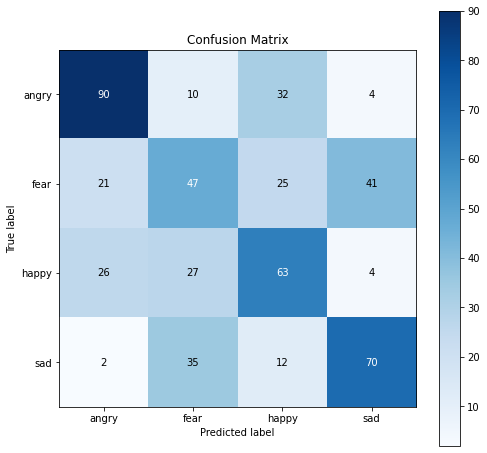

In [ ]:
skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# Tempogram + conv1D

In [ ]:
audio_duration = 3
sampling_rate = 22050
input_length = sampling_rate * audio_duration

In [ ]:
data = {'labels': [],
        'features': []}

for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      data['labels'].append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      data['labels'].append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      data['labels'].append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      data['labels'].append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])
    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")
    tempogram = librosa.feature.tempogram(signal, sr)
    data['features'].append(tempogram)



In [ ]:
X = data['features']
y = data['labels']

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((4117, 384, 130), (509, 384, 130), (4117, 4), (509, 4))

### conv1D

In [ ]:

# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

#LSTM Configuration
num_lstm = 256

In [ ]:
model = Sequential(name='Audio_CNN_1D')

# LFLB1
model.add(Conv1D(filters=64, kernel_size=(3), strides=1, padding='same', data_format='channels_last',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.5))

# LFLB2
model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB3
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB4
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LSTM
model.add(LSTM(units=num_lstm))

# FC
model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt= keras.optimizers.Adam(lr=0.01, beta_1=0.9,  beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()


Model: "Audio_CNN_1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 384, 64)           25024     
_________________________________________________________________
batch_normalization (BatchNo (None, 384, 64)           256       
_________________________________________________________________
activation (Activation)      (None, 384, 64)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 96, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 96, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 64)            12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 64)           

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Audio_1DCNN.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
258/258 [==============================] - 57s 17ms/step - loss: 1.3297 - categorical_accuracy: 0.3860 - val_loss: 1.2660 - val_categorical_accuracy: 0.4039
Epoch 2/200
258/258 [==============================] - 3s 11ms/step - loss: 1.2090 - categorical_accuracy: 0.4363 - val_loss: 1.3157 - val_categorical_accuracy: 0.3515
Epoch 3/200
258/258 [==============================] - 3s 11ms/step - loss: 1.1967 - categorical_accuracy: 0.4283 - val_loss: 1.4915 - val_categorical_accuracy: 0.2860
Epoch 4/200
258/258 [==============================] - 3s 11ms/step - loss: 1.1713 - categorical_accuracy: 0.4635 - val_loss: 1.2189 - val_categorical_accuracy: 0.4192
Epoch 5/200
258/258 [==============================] - 3s 11ms/step - loss: 1.1597 - categorical_accuracy: 0.4676 - val_loss: 1.5529 - val_categorical_accuracy: 0.2511
Epoch 6/200
258/258 [==============================] - 3s 11ms/step - loss: 1.1648 - categorical_accuracy: 0.4532 - val_loss: 1.1561 - val_categorical_accuracy

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/conv1D_tempogram_cremad.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.41      0.97      0.58       136
        fear       0.42      0.23      0.30       134
       happy       0.24      0.11      0.15       120
         sad       0.60      0.30      0.40       119

    accuracy                           0.42       509
   macro avg       0.42      0.40      0.36       509
weighted avg       0.42      0.42      0.36       509



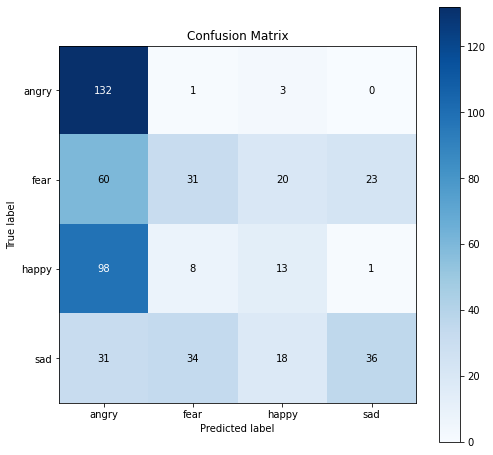

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# Tempogram + conv2D

In [ ]:
data = {'labels': [],
        'features': []}

for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      data['labels'].append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      data['labels'].append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      data['labels'].append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      data['labels'].append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])
    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")
    tempogram = librosa.feature.tempogram(signal, sr)
    tempogram = np.expand_dims(tempogram, axis=-1)
    data['features'].append(tempogram)


In [ ]:
X = data['features']
y = data['labels']

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((4117, 384, 130, 1), (509, 384, 130, 1), (4117, 4), (509, 4))

### conv2D

In [ ]:
# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

In [ ]:
model = Sequential(name='Audio_CNN_2D')

# LFLB1
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt = optimizers.SGD(lr=learning_rate, decay=decay, momentum=momentum, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()

Model: "Audio_CNN_2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 384, 130, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 384, 130, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 384, 130, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 192, 65, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 192, 65, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 65, 64)       36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 192, 65, 64)      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Modelfull_2_1.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
258/258 [==============================] - 59s 51ms/step - loss: 3.6280 - categorical_accuracy: 0.3540 - val_loss: 2.2346 - val_categorical_accuracy: 0.2380
Epoch 2/200
258/258 [==============================] - 12s 47ms/step - loss: 1.8571 - categorical_accuracy: 0.4071 - val_loss: 1.1795 - val_categorical_accuracy: 0.4563
Epoch 3/200
258/258 [==============================] - 12s 46ms/step - loss: 1.7286 - categorical_accuracy: 0.4275 - val_loss: 1.6968 - val_categorical_accuracy: 0.3755
Epoch 4/200
258/258 [==============================] - 12s 46ms/step - loss: 1.5730 - categorical_accuracy: 0.4307 - val_loss: 2.2555 - val_categorical_accuracy: 0.2860
Epoch 5/200
258/258 [==============================] - 12s 46ms/step - loss: 1.5309 - categorical_accuracy: 0.4413 - val_loss: 1.4101 - val_categorical_accuracy: 0.3952
Epoch 6/200
258/258 [==============================] - 12s 46ms/step - loss: 1.5309 - categorical_accuracy: 0.4319 - val_loss: 1.3643 - val_categorical_acc

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/conv2D_tempogram_cremad.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.65      0.10      0.17       136
        fear       0.33      0.37      0.35       134
       happy       0.24      0.27      0.25       120
         sad       0.39      0.67      0.49       119

    accuracy                           0.34       509
   macro avg       0.40      0.35      0.32       509
weighted avg       0.41      0.34      0.31       509



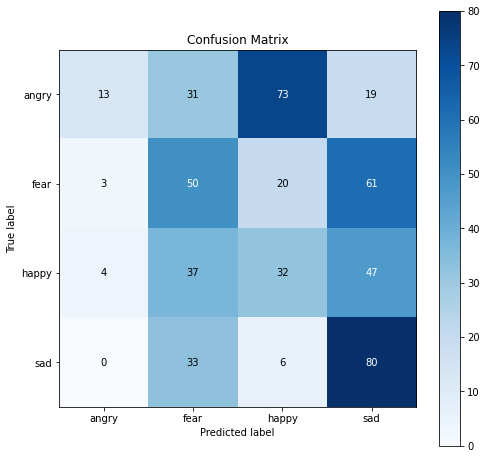

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# Combined feature + basic model

In [ ]:
data = {'labels': [],
        'features': []}

for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      data['labels'].append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      data['labels'].append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      data['labels'].append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      data['labels'].append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])
    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")
    mfcc = np.mean(librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=39).T,axis=0)
    mel_spec = np.mean(librosa.feature.melspectrogram(signal, sr, n_mels=28).T, axis=0)
    tempogram = np.mean(librosa.feature.tempogram(signal, sr, win_length=24).T, axis=0)

    mfcc = pd.DataFrame(mfcc)
    mel_spec = pd.DataFrame(mel_spec)
    tempogram = pd.DataFrame(tempogram)
    feature = mfcc.append(mel_spec).append(tempogram)
    feature = np.array(feature[0])
    data['features'].append(feature)


In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
data['features'] = sc.fit_transform(data['features'])

In [ ]:
X = data['features']
y = data['labels']

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape

(4117, 91)

## basic models:

In [ ]:
model = Sequential()
model.add(Dense(91, input_shape=(91, ), activation = 'relu'))
#model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(4, activation = 'softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 91)                8372      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               11776     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 516       
Total params: 37,176
Trainable params: 37,176
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=200, 
                    validation_data=(X_val, y_val))

Epoch 1/200
65/65 [==============================] - 1s 6ms/step - loss: 1.1581 - accuracy: 0.4873 - val_loss: 1.0182 - val_accuracy: 0.5524
Epoch 2/200
65/65 [==============================] - 0s 3ms/step - loss: 0.9013 - accuracy: 0.6021 - val_loss: 0.9970 - val_accuracy: 0.5677
Epoch 3/200
65/65 [==============================] - 0s 3ms/step - loss: 0.8402 - accuracy: 0.6462 - val_loss: 0.9428 - val_accuracy: 0.5961
Epoch 4/200
65/65 [==============================] - 0s 3ms/step - loss: 0.7738 - accuracy: 0.6800 - val_loss: 0.9652 - val_accuracy: 0.5742
Epoch 5/200
65/65 [==============================] - 0s 3ms/step - loss: 0.7298 - accuracy: 0.7018 - val_loss: 0.9275 - val_accuracy: 0.6332
Epoch 6/200
65/65 [==============================] - 0s 3ms/step - loss: 0.6968 - accuracy: 0.7070 - val_loss: 1.0159 - val_accuracy: 0.5917
Epoch 7/200
65/65 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.7402 - val_loss: 0.9589 - val_accuracy: 0.6223
Epoch 8/200
6

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/basic_combined_cremad.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.70      0.68      0.69       136
        fear       0.58      0.44      0.50       134
       happy       0.47      0.57      0.52       120
         sad       0.65      0.71      0.67       119

    accuracy                           0.60       509
   macro avg       0.60      0.60      0.60       509
weighted avg       0.60      0.60      0.60       509



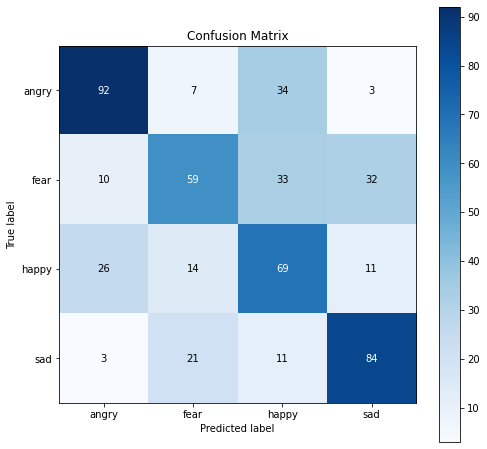

In [ ]:
skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))